In [1]:
import osmnx as ox
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import numpy as np
from shapely.geometry import Point
from matplotlib.lines import Line2D

# Suppress warnings
ox.settings.log_console = False
ox.settings.use_cache = True

In [2]:
place = "Lahore District, Pakistan"

boundary = ox.geocode_to_gdf(place)
# 
latitude = 31.5204
longitude = 74.3587

gdf = gpd.GeoDataFrame(
    {'geometry': [Point(longitude, latitude)]},
    crs="EPSG:4326"  # WGS84
)


gdf_utm = ox.projection.project_gdf(gdf)
gdf_utm.to_file("utm_point.gpkg", driver="GPKG")


In [3]:
gdf_utm = gpd.read_file("utm_point.gpkg")

utm_crs = gdf_utm.crs
print("UTM CRS:", utm_crs)

UTM CRS: EPSG:32643


In [4]:
pois = ox.features_from_place(place, {
    'amenity': ['hospital', 'university', 'college'],
    'shop': ['supermarket', 'mall'],
    'building': ['retail', 'commercial']
})

In [5]:

def filter_pois(df, conditions):
    return df[conditions][['geometry', 'name']].copy()

hospitals = filter_pois(pois, pois['amenity'] == 'hospital').assign(type='hospital')
universities = filter_pois(pois, pois['amenity'].isin(['university', 'college'])).assign(type='education')
markets = filter_pois(pois, pois['shop'].isin(['supermarket','mall']) | 
                   pois['building'].isin(['retail','commercial'])).assign(type='market')

all_pois = gpd.GeoDataFrame(
    gpd.pd.concat([hospitals, universities, markets]), 
    crs=pois.crs
)

In [6]:
# Convert polygons to points
all_pois.geometry = all_pois.geometry.apply(
    lambda geom: geom.centroid if geom.type in ['Polygon','MultiPolygon'] else geom
)

/tmp/ipykernel_5564/4254518540.py:3: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  lambda geom: geom.centroid if geom.type in ['Polygon','MultiPolygon'] else geom


In [7]:
all_pois

geometry                          name  \
element id                                                                    
node    271105745    POINT (74.3715 31.47673)  DHA Medical Center Phase III   
        526681507   POINT (74.31162 31.50248)              PU Health Center   
        563684371   POINT (74.34049 31.50868)         یونائیٹڈ کرسچن ہسپتال   
        674141730   POINT (74.26318 31.49678)      Social Security Hospital   
        1357553198  POINT (74.29927 31.46985)               Saadan Hospital   
...                                       ...                           ...   
way     1414840359   POINT (74.14256 31.3849)                        Shop 1   
        1414840360  POINT (74.14254 31.38493)                        Shop 1   
        1414840361   POINT (74.1426 31.38484)                        Shop 1   
        1414840362  POINT (74.14258 31.38487)                        Shop 1   
        1417455185  POINT (74.28061 31.55077)    Imtiaz Mega Gulshan-e-Ravi   

                        type  
element id                    
node    271105745   hospital  
        526681507   hospital  
        563684371   hospital  
        674141730   hospital  
        1357553198  hospital  
...                      ...  
way     1414840359    market  
        1414840360    market  
        1414840361    market  
        1414840362    market  
        1417455185    market  

[1191 rows x 3 columns]

In [8]:
all_pois.to_file("all_pois.gpkg", layer='pois', driver="GPKG")


In [9]:
all_pois = gpd.read_file("all_pois.gpkg", layer='pois')


In [10]:
all_pois

,element,id,name,type,geometry
0,node,271105745,DHA Medical Center Phase III,hospital,POINT (74.3715 31.47673)
1,node,526681507,PU Health Center,hospital,POINT (74.31162 31.50248)
2,node,563684371,یونائیٹڈ کرسچن ہسپتال,hospital,POINT (74.34049 31.50868)
3,node,674141730,Social Security Hospital,hospital,POINT (74.26318 31.49678)
4,node,1357553198,Saadan Hospital,hospital,POINT (74.29927 31.46985)
...,...,...,...,...,...
1186,way,1414840359,Shop 1,market,POINT (74.14256 31.3849)
1187,way,1414840360,Shop 1,market,POINT (74.14254 31.38493)
1188,way,1414840361,Shop 1,market,POINT (74.1426 31.38484)
1189,way,1414840362,Shop 1,market,POINT (74.14258 31.38487)


In [11]:
# bus-compatible roads
G = ox.graph_from_polygon(
    boundary.geometry.iloc[0], 
    network_type='drive',  
    truncate_by_edge=True
)


boundary = boundary.to_crs(utm_crs)
all_pois = all_pois.to_crs(utm_crs)
G = ox.project_graph(G, to_crs=utm_crs)



In [12]:
print(len(G.nodes))
print(len(G.edges))

145131
378090


In [13]:
ox.save_graphml(G, filepath="network.graphml")

In [14]:
G = ox.load_graphml("network.graphml")


In [15]:
edges = ox.graph_to_gdfs(G, nodes=False, edges=True)
major_roads = edges[edges['highway'].isin(['primary', 'secondary', 'trunk'])]

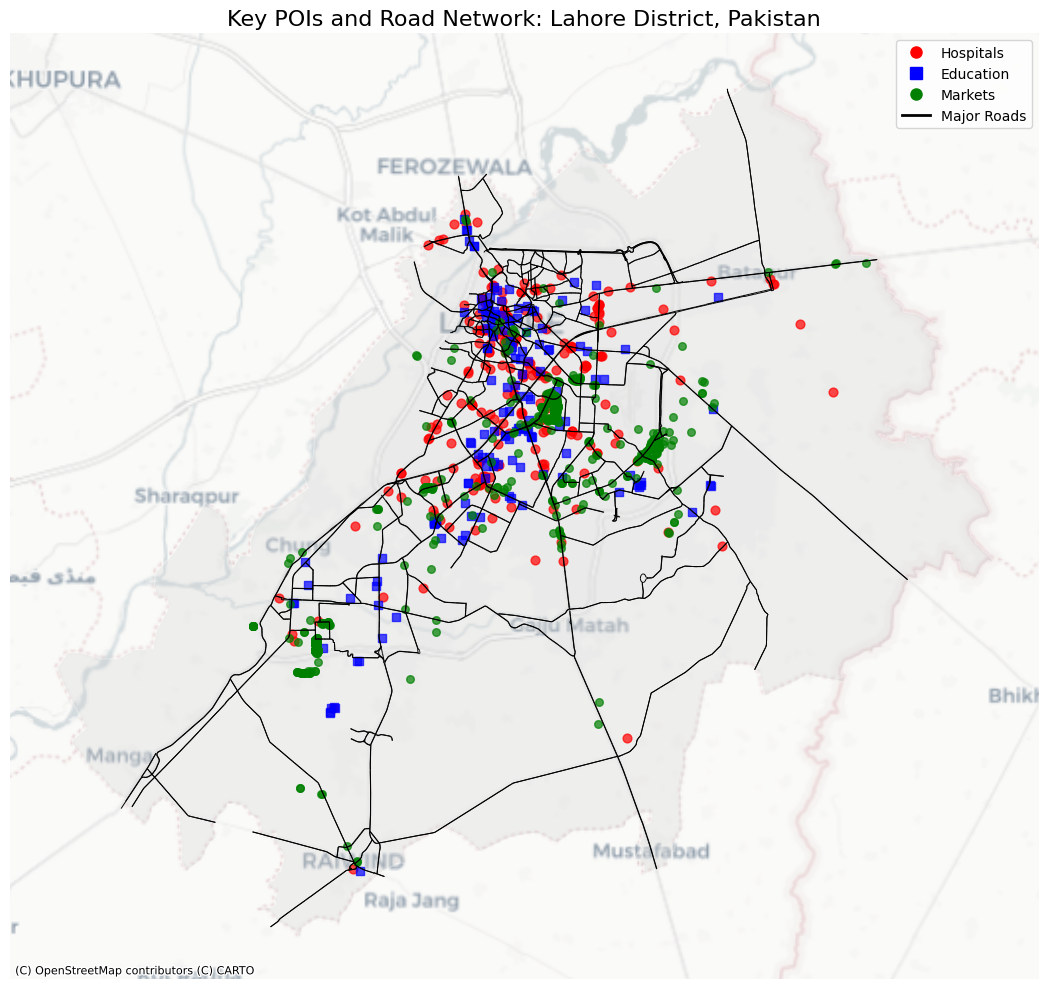


POIs Found in Lahore:
- Hospitals: 227
- Education Institutions: 160
- Markets: 804
- Total POIs: 1191
- Road Network: 378090 edges



In [16]:
# VISUALIZATION 
fig, ax = plt.subplots(figsize=(12, 10))

boundary.plot(ax=ax, color='lightgray', edgecolor='white', alpha=0.3)
major_roads.plot(ax=ax, color='black', linewidth=0.7)

poi_colors = {'hospital': 'red', 'education': 'blue', 'market': 'green'}
for ptype, color in poi_colors.items():
    subset = all_pois[all_pois['type'] == ptype]
    subset.plot(ax=ax, color=color, markersize=30 + 10*(ptype == 'hospital'), 
               alpha=0.7, marker='o' if ptype != 'education' else 's')

ctx.add_basemap(ax, crs=utm_crs, source=ctx.providers.CartoDB.Positron)

legend_elements = [
    Line2D([0], [0], color='red', lw=0, marker='o', markersize=8, label='Hospitals'),
    Line2D([0], [0], color='blue', lw=0, marker='s', markersize=8, label='Education'),
    Line2D([0], [0], color='green', lw=0, marker='o', markersize=8, label='Markets'),
    Line2D([0], [0], color='black', lw=2, label='Major Roads')
]
ax.legend(handles=legend_elements, loc='upper right')
ax.set_title(f"Key POIs and Road Network: {place}", fontsize=16)
ax.axis('off')

plt.tight_layout()
plt.savefig('Lahore_pois_network.png', dpi=300)
plt.show()

print("\n" + "="*50)
print(f"POIs Found in Lahore:")
print(f"- Hospitals: {len(hospitals)}")
print(f"- Education Institutions: {len(universities)}")
print(f"- Markets: {len(markets)}")
print(f"- Total POIs: {len(all_pois)}")
print(f"- Road Network: {len(edges)} edges")
print("="*50 + "\n")
